In [2]:
import snap
import random
import numpy as np
import matplotlib.pyplot as plt
import powerlaw
import math
import networkx as nx

In [3]:
def UndirectMe(G):
    GU = snap.TUNGraph.New()
    for N in G.Nodes():
        NId = N.GetId()
        GU.AddNode(NId)
        Gu.AddNode(2 * NId)
    
    for E in G.Edges():
        Src = E.GetSrcNId()
        Dst = E.GetDstNId()
        
        
    

In [4]:
def loadDirectedSigns(filename):
    """
    :param - filename: undirected graph with associated edge sign
    return type: dictionary (key = node pair (a,b), value = sign)
    return: Return sign associated with node pairs. Both pairs, (a,b) and (b,a)
    are stored as keys. Self-edges are NOT included.
    """
    signs = {}
    with open(filename, 'r') as ipfile:
      for line in ipfile:
        if line[0] != '#':
            if filename[-3:] == "csv":
              line_arr = line.split(',')
            else:
              line_arr = line.split()
            if line_arr[0] == line_arr[1]:
              continue
            node1 = int(line_arr[0])
            node2 = int(line_arr[1])
            sign = int(line_arr[2])
            signs[(node1, node2)] = sign

    return signs

In [5]:
def GetNetworkxG(G, signs):
    Gnx = nx.DiGraph()
    Gnxu = nx.Graph()
    for N in G.Nodes():
        Gnx.add_node(N.GetId())
        Gnxu.add_node(N.GetId())
    for E in G.Edges():
        src = E.GetSrcNId()
        dst = E.GetDstNId()
        Gnx.add_weighted_edges_from([(src, dst, signs[(src, dst)])])
        Gnxu.add_weighted_edges_from([(src, dst, signs[(src, dst)])]) 
        
    return Gnx, Gnxu

In [6]:
def makeSignsPositive(signs):
    minSign = min(signs.values())
    modMinSign = abs(minSign)
    newSigns = {}
    for i in signs.keys():
        newSigns[i] = signs[i] + modMinSign + 1
    return newSigns

In [7]:
def GetCNCoeff(G, signs, x ,y):
    # signs > 0
    # x -> y
    
    xo = GetNeighO(G, signs, x)
    xi = GetNeighI(G, signs, x)
    yo = GetNeighO(G, signs, y)
    yi = GetNeighI(G, signs, y)
    
    # wxy
    woo = sum([xo[i] if i in yo.keys() else 0 for i in xo.keys()])
    wio = sum([xi[i] if i in yo.keys() else 0 for i in xi.keys()])
    woi = sum([xo[i] if i in yi.keys() else 0 for i in xo.keys()])
    wii = sum([xi[i] if i in yi.keys() else 0 for i in xi.keys()])
    
    return woo, wio, woi, wii

In [8]:
def GetJaccardCoeff(G, signs, x, y):
    # signs > 0
    # x -> y
    
    xo = GetNeighO(G, signs, x)
    xi = GetNeighI(G, signs, x)
    yo = GetNeighO(G, signs, y)
    yi = GetNeighI(G, signs, y)
    
    # nxy
    noo = sum([xo[i] if i in yo.keys() else 0 for i in xo.keys()])
    nio = sum([xi[i] if i in yo.keys() else 0 for i in xi.keys()])
    noi = sum([xo[i] if i in yi.keys() else 0 for i in xo.keys()])
    nii = sum([xi[i] if i in yi.keys() else 0 for i in xi.keys()])
    
    #dxy
    doo = sum(xo.values()) + sum(yo.values())
    dio = sum(xi.values()) + sum(yo.values())
    doi = sum(xo.values()) + sum(yi.values())
    dii = sum(xi.values()) + sum(yi.values())
    
    foo = 1.0 * noo / doo if doo != 0 else 0
    fio = 1.0 * nio / dio if dio != 0 else 0
    foi = 1.0 * noi / doi if doi != 0 else 0
    fii = 1.0 * nii / dii if dii != 0 else 0
    
    return foo, fio, foi, fii

In [9]:
def PACoeff(G, signs, x, y):
    # signs > 0
    # x -> y
    
    xo = GetNeighO(G, signs, x)
    xi = GetNeighI(G, signs, x)
    yo = GetNeighO(G, signs, y)
    yi = GetNeighI(G, signs, y)
    
    woo = sum(xo.values()) * sum(yo.values())
    wio = sum(xi.values()) * sum(yo.values())
    woi = sum(xo.values()) * sum(yi.values())
    wii = sum(xi.values()) * sum(yi.values())
    
    return woo, wio, woi, wii

In [10]:
def AACoeff(G, signs, x, y, VolO, VolI, Vol):
    
    xo = GetNeighO(G, signs, x)
    xi = GetNeighI(G, signs, x)
    yo = GetNeighO(G, signs, y)
    yi = GetNeighI(G, signs, y)
        
    woo = sum([1.0 * (xo[z] + yo[z]) / math.log(1 + VolI[z]) if z in yo.keys() else 0 for z in xo.keys()])
    wio = sum([1.0 * (xi[z] + yo[z]) / math.log(1 + Vol[z]) if z in yo.keys() else 0 for z in xi.keys()])
    woi = sum([1.0 * (xo[z] + yi[z]) / math.log(1 + Vol[z]) if z in yi.keys() else 0 for z in xo.keys()])
    wii = sum([1.0 * (xi[z] + yi[z]) / math.log(1 + VolO[z]) if z in yi.keys() else 0 for z in xi.keys()])
    
    return woo, wio, woi, wii

In [11]:
def RACoeff(G, signs, x, y, VolO, VolI, Vol):
    
    xo = GetNeighO(G, signs, x)
    xi = GetNeighI(G, signs, x)
    yo = GetNeighO(G, signs, y)
    yi = GetNeighI(G, signs, y)
        
    woo = sum([1.0 * (xo[z] + yo[z]) / VolI[z] if z in yo.keys() else 0 for z in xo.keys()])
    wio = sum([1.0 * (xi[z] + yo[z]) / Vol[z] if z in yo.keys() else 0 for z in xi.keys()])
    woi = sum([1.0 * (xo[z] + yi[z]) / Vol[z] if z in yi.keys() else 0 for z in xo.keys()])
    wii = sum([1.0 * (xi[z] + yi[z]) / VolO[z] if z in yi.keys() else 0 for z in xi.keys()])
    
    return woo, wio, woi, wii

In [12]:
def CCCoeff(G, signs, x, y, C):
    return C[x] + C[y]

In [13]:
def GetNeighO(G, signs, NId):
    N = G.GetNI(NId)
    Neighs = {}
    OutDeg = N.GetOutDeg()
    for i in range(OutDeg):
        Neigh = N.GetOutNId(i)
        Weight = signs[(N.GetId(), Neigh)]
        Neighs[Neigh] = Weight
    return Neighs

def GetNeighI(G, signs, NId):
    N = G.GetNI(NId)
    Neighs = {}
    InDeg = N.GetInDeg()
    for i in range(InDeg):
        Neigh = N.GetInNId(i)
        Weight = signs[(Neigh, N.GetId())]
        Neighs[Neigh] = Weight
    return Neighs

def GetVolO(G, signs, NId):
    return sum(GetNeighO(G, signs, NId).values())

def GetVolI(G, signs, NId):
    return sum(GetNeighI(G, signs, NId).values())

def GetVol(G, signs, NId):
    return GetVolO(G, signs, NId) + GetVolI(G, signs, NId)

In [14]:
G = snap.LoadEdgeList(snap.PNGraph, "Datasets/soc-sign-bitcoinotc.csv", 0, 1, ',')
signs = loadDirectedSigns("Datasets/soc-sign-bitcoinotc.csv")
pSigns = makeSignsPositive(signs)
Gnx, Gnxu = GetNetworkxG(G, signs)

c = 0
Vol = {}
VolI = {}
VolO = {}
CC = {}
for N in G.Nodes():
    CC[N.GetId()] = nx.clustering(Gnxu, N.GetId())
    VolO[N.GetId()] = GetVolO(G, pSigns, N.GetId())
    VolI[N.GetId()] = GetVolI(G, pSigns, N.GetId())
    Vol[N.GetId()] = GetVol(G, pSigns, N.GetId())

M = []
Y = []
for e in G.Edges():
    if c % 100 == 0:
        print c,
    f = []
    src = e.GetSrcNId()
    dst = e.GetDstNId()

    c1,c2,c3,c4 = GetCNCoeff(G, pSigns, src, dst)
    f.append(c1)
    f.append(c2)
    f.append(c3)
    f.append(c4)
    
    c1,c2,c3,c4 = GetJaccardCoeff(G, pSigns, src, dst)
    f.append(c1)
    f.append(c2)
    f.append(c3)
    f.append(c4)

    c1,c2,c3,c4 = PACoeff(G, pSigns, src, dst)
    f.append(c1)
    f.append(c2)
    f.append(c3)
    f.append(c4)
    
    c1,c2,c3,c4 = AACoeff(G, pSigns, src, dst, VolO, VolI, Vol)
    f.append(c1)
    f.append(c2)
    f.append(c3)
    f.append(c4)

    c1,c2,c3,c4 = RACoeff(G, pSigns, src, dst, VolO, VolI, Vol)
    f.append(c1)
    f.append(c2)
    f.append(c3)
    f.append(c4)

    c1 = CCCoeff(G, pSigns, src, dst, CC)
    f.append(c1)
    
    f.append(1)
    
    M.append(f)
    Y.append(pSigns[src, dst])
    
    c += 1


0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300 8400 8500 8600 8700 8800 8900 9000 9100 9200 9300 9400 9500 9600 9700 9800 9900 10000 10100 10200 10300 10400 10500 10600 10700 10800 10900 11000 11100 11200 11300 11400 11500 11600 11700 11800 11900 12000 12100 12200 12300 12400 12500 12600 12700 12800 12900 13000 13100 13200 13300 13400 13500 13600 13700 13800 13900 14000 14100 14200 14300 14400 14500 14600 14700 14800 14900 15000 15100 15200 15300 15400 15500 15600 15700 15800 15900 16000 16100 16200 16300 16400 16500 16600 16700 16800 16900 17000 17100 17200 17300 17400 17500 17600 17700 17800 17900 18000 18100 18200 18300 18400 18

In [1]:
Mn = np.array(M)
Yn = np.array(Y)
print Mn.shape, Yn.shape
coefficients = np.linalg.lstsq(Mn, Yn)[0]
print coefficients.shape

NameError: name 'np' is not defined

28200 35592 35592
[20250, 4160, 1486, 596, 446, 156, 134, 118, 112, 286, 20, 234, 80, 38, 18, 20, 0, 4, 4, 14, 24, 0]


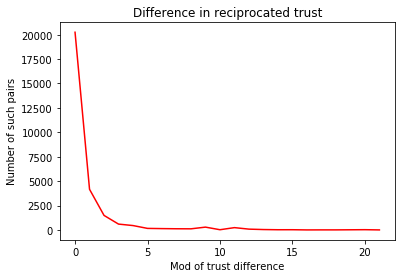

In [76]:
count = 0
e = 0
diff = [0 for i in range(max(pSigns.values()) + 1)]
for N in G.Nodes():
    NId = N.GetId()
    OutDeg = N.GetOutDeg()
    for i in range(OutDeg):
        e += 1
        Neigh = N.GetOutNId(i)
        if G.IsEdge(Neigh, NId):
            count += 1
            diff[abs(signs[(Neigh, NId)] - signs[(NId, Neigh)])] += 1

print count, e, G.GetEdges()
print diff
plt.plot(range(22), diff, color = 'r', label = "Reciprocation trust difference")
plt.xlabel('Mod of trust difference')
plt.ylabel('Number of such pairs')
plt.title('Difference in reciprocated trust')
plt.show()

In [5]:
CmtyV = snap.TCnComV()
modularity = snap.CommunityCNM(G, CmtyV)
for Cmty in CmtyV:
    print "Community: " + str(len(Cmty))
#     for NI in Cmty:
#         print NI
print "The modularity of the network is %f" % modularity


Community: 1991
Community: 1671
Community: 623
Community: 6
Community: 451
Community: 592
Community: 94
Community: 4
Community: 6
Community: 44
Community: 31
Community: 3
Community: 171
Community: 2
Community: 3
Community: 2
Community: 11
Community: 3
Community: 3
Community: 2
Community: 4
Community: 3
Community: 3
Community: 2
Community: 3
Community: 4
Community: 2
Community: 4
Community: 3
Community: 12
Community: 2
Community: 2
Community: 12
Community: 2
Community: 14
Community: 2
Community: 6
Community: 2
Community: 6
Community: 3
Community: 2
Community: 2
Community: 8
Community: 2
Community: 2
Community: 2
Community: 2
Community: 4
Community: 2
Community: 2
Community: 2
Community: 4
Community: 16
Community: 3
Community: 3
Community: 6
Community: 7
Community: 4
Community: 2
Community: 2
The modularity of the network is 0.455962
